In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math

# Importing the dataset

In [2]:
polish_data = pd.read_csv(r"polish_data.csv")
print(polish_data.head())

   time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0  6062445  4368335  3.8   5.2     0.13
1    11          11  6062500  4368343  5.1   5.2     0.12
2    20           9  6062556  4368351  6.3   5.2    -0.10
3    29           9  6062600  4368359  5.3   5.4     0.35
4    39          10  6062655  4368367  8.8   5.3    -0.12


## Conversion functions:

In [3]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

## Formulas fo the excelleration in the X and Y axis:

In [4]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

In [5]:
def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

## Predicting the Proccess error covariance $P_{k}^{-}$ :

In [6]:
def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

## Kalman gain $K_k$ :

In [7]:
def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

## A posteriori estimate $\hat{x}_k$ :

In [8]:
def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

## Update proccess error cov $P_k$

In [9]:
def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

In [10]:
def calc_a_xy(arr_in, arr_prev):
    
    sog_now = arr_in[5]
    sog_prev = arr_prev[5]
    
    cog_now = arr_in[4]*np.pi/180
    cog_prev = arr_prev[4]*np.pi/180
    
    rot_now = arr_in[6]*np.pi/180
    
    delta_time = arr_in[1]
    
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time
    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y
    

In [11]:
def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]
    
    x = arr_in[2]
    y = arr_in[3]
    Vx = sog*np.cos(deg_to_rad(cog))
    Vy = sog*np.sin(deg_to_rad(cog))
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

## Kalman Filter:

In [85]:

R = np.diag(np.array([1000,100,0.1,0.05]))
print(R)

[[1.e+03 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-01 0.e+00]
 [0.e+00 0.e+00 0.e+00 5.e-02]]


[]

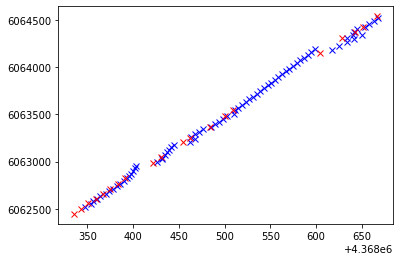

In [168]:
# Declaring the constants for Kalman filter:
A = get_mat_A(1)
P_k = np.array([[50],[10],[0.2],[0.1]]).dot(np.transpose(np.array([[50],[10],[0.2],[0.1]])))
H = np.identity(4)
I = np.identity(4)


# Sensitivity measures, deep copy to avoid address pointers:
R = np.diag(np.array([5,5,-0.8,-0.8]))
R = np.diag(np.array([20,20,0.3,0.3]))

Q = copy.deepcopy(P_k)

# Kalman Initial state
X_state = np.array([[0],[0],[0],[0]])
ax_arr = []
ay_arr = []

X_save_states = []

polish_counter = 1 # counter for the original data set obsevations
for i in range(0,380):
    
    '''If we observe the value we observe this'''
    if(polish_data.iloc[polish_counter,0] == i and polish_counter < 21):
        zk_prev = polish_data.iloc[polish_counter-1,:].values
        z_k = polish_data.iloc[polish_counter,:].values # convert to numpy array -observed value
        
        delta_TIME = copy.deepcopy(z_k[1])
            
        ax, ay = calc_a_xy(z_k,zk_prev)
        ax_arr.append(ax)
        ay_arr.append(ay)
        
        z_k = copy.deepcopy(convert_state(z_k))
       
        X_state = copy.deepcopy(convert_state(zk_prev))
        #Kalman Predict        
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))
        
        # Measuremenet update
        Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
        X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
        P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))
        
        X_save_states.append(copy.deepcopy(X_state))
        
        polish_counter += 1
        #print(z_k, '\n')
    else:
        '''This code will be excecuted when we have no observation'''
        ay = 0
        ax = 0
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))
        X_save_states.append(copy.deepcopy(X_state))
        
        

# Saving the coordinates:
X_coord = []
Y_coord = []

X_orig = polish_data.iloc[:,2]
Y_orig = polish_data.iloc[:,3]

for i in range(0,380):
    if i > 10 and i % 5 == 0:
        X_coord.append(X_save_states[i][0][0])
        #print(X_save_states[i][0][0])
        Y_coord.append(X_save_states[i][1][0])

    
#plt.plot(X_coord[11:380], Y_coord[11:380], "bx")
plt.plot(Y_coord,X_coord, "bx")
plt.plot(Y_orig,X_orig, "rx")
#legend_data = bp
plt.plot()
    

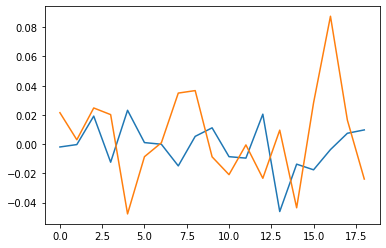

In [113]:
plt.plot(ax_arr)
plt.plot(ay_arr)

[]

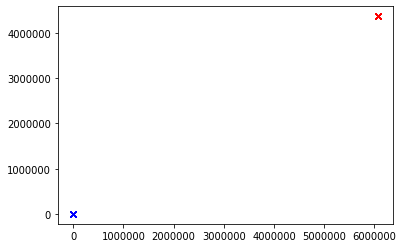

In [171]:
X_coord = []
Y_coord = []

X_orig = polish_data.iloc[:,2]
Y_orig = polish_data.iloc[:,3]

for i in range(0,380):
    X_coord.append(X_save_states[i][0][0])
        #print(X_save_states[i][0][0])
    Y_coord.append(X_save_states[i][1][0])

    
#plt.plot(X_coord[11:380], Y_coord[11:380], "bx")
plt.plot(X_coord, Y_coord, "bx")
plt.plot(X_orig,Y_orig, "rx")
plt.plot()

In [32]:
polish_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0,0,6062445,4368335,3.8,5.2,0.13
1,11,11,6062500,4368343,5.1,5.2,0.12
2,20,9,6062556,4368351,6.3,5.2,-0.10
3,29,9,6062600,4368359,5.3,5.4,0.35
4,39,10,6062655,4368367,8.8,5.3,-0.12
5,50,11,6062711,4368375,7.6,5.5,-0.42
6,60,10,6062766,4368383,3.4,5.5,0.33
7,71,11,6062822,4368391,6.7,5.5,-0.29
8,99,28,6062988,4368422,3.8,5.3,0.50
9,110,11,6063043,4368430,8.8,5.4,-0.07


# Error Comparison:

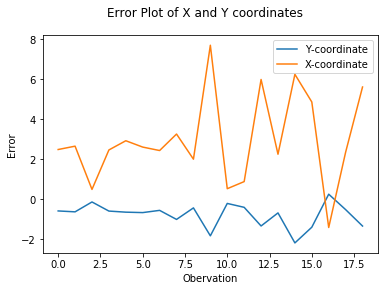

In [228]:
time_intervals = polish_data.iloc[:,0].values
X_pred_err = []
Y_pred_err = []

for i in range(1, len(time_intervals)):
    X_pred_err.append(X_coord[time_intervals[i]] - X_orig[i])
    Y_pred_err.append(Y_coord[time_intervals[i]] - Y_orig[i])

plt.plot(X_pred_err)
plt.plot(Y_pred_err)
plt.ylabel('Error')
plt.xlabel('Obervation')
plt.suptitle('Error Plot of X and Y coordinates')

legend_data = np.array(["Y-coordinate", "X-coordinate"])
plt.legend(legend_data, loc = 'best')

plt.show()

In [238]:
MSE_X = np.sum(np.array(X_pred_err)**2)/len(X_pred_err)
MSE_Y = np.sum(np.array(Y_pred_err)**2)/len(X_pred_err)
print("Mean squared error for X Coordinates: ",MSE_X)
print("Mean squared error for Y Coordinates: ",MSE_Y)

Mean squared error for X Coordinates:  0.9687536795088068
Mean squared error for Y Coordinates:  13.53894138218449


In [261]:
np.corrcoef(X_pred_err,X_orig[1:20].values)

array([[ 1.        , -0.29016575],
       [-0.29016575,  1.        ]])

In [262]:
np.corrcoef(Y_pred_err,Y_orig[1:20].values)

array([[1.        , 0.19722668],
       [0.19722668, 1.        ]])

In [266]:
print("X-Correlation Coef:\n", np.corrcoef(X_pred_err,X_orig[1:20].values))
print("\nY-Correlation Coef:\n", np.corrcoef(Y_pred_err,Y_orig[1:20].values))

X-Correlation Coef:
 [[ 1.         -0.29016575]
 [-0.29016575  1.        ]]

Y-Correlation Coef:
 [[1.         0.19722668]
 [0.19722668 1.        ]]
